In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/soil-measures/soil_measures.csv")
df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [3]:
#The output informs that there aren't any missing values in our dataset
df.isna().sum().sort_values()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [4]:
#There is minute differences in the measure of cetranl tendencies, 
#but it is always better to center the data and there aren't any categorical data or string data so we don't need to encode anything
print(df.describe())
print(df['crop'].unique())
print(df['crop'].nunique())

                 N            P            K           ph
count  2200.000000  2200.000000  2200.000000  2200.000000
mean     50.551818    53.362727    48.149091     6.469480
std      36.917334    32.985883    50.647931     0.773938
min       0.000000     5.000000     5.000000     3.504752
25%      21.000000    28.000000    20.000000     5.971693
50%      37.000000    51.000000    32.000000     6.425045
75%      84.250000    68.000000    49.000000     6.923643
max     140.000000   145.000000   205.000000     9.935091
['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']
22


In [5]:
#Diving the dataset before centering so that it does not have data leakage(This can lead to information about the test set leaking into the training set)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
X = df.drop("crop", axis=1).values 
y = df["crop"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  
random_state=116)
#Among Standard, MinMax and Robust Scalers. The Robusst Scaler is better for our situation
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Doing LabelEncoder for target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [6]:
#From the output we can understand there isn't any class imbalance too,
#So we don't need to do stratification
unique_classes, class_counts = np.unique(y, return_counts=True)
class_counts_dict = dict(zip(unique_classes, class_counts))

print(class_counts_dict)

{'apple': 100, 'banana': 100, 'blackgram': 100, 'chickpea': 100, 'coconut': 100, 'coffee': 100, 'cotton': 100, 'grapes': 100, 'jute': 100, 'kidneybeans': 100, 'lentil': 100, 'maize': 100, 'mango': 100, 'mothbeans': 100, 'mungbean': 100, 'muskmelon': 100, 'orange': 100, 'papaya': 100, 'pigeonpeas': 100, 'pomegranate': 100, 'rice': 100, 'watermelon': 100}


In [7]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((1650, 4), (1650,), (550, 4), (550,))

In [8]:
train_accuracies = []
test_accuracies = []
f1_scores = []
recall_scores = []
precision_scores = []

### KNN

In [9]:
"""from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
knn = KNeighborsClassifier(22)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))"""

'from sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.metrics import classification_report\nknn = KNeighborsClassifier(22)\nknn.fit(X_train_scaled,y_train)\ny_pred = knn.predict(X_test_scaled)\nprint(classification_report(y_test, y_pred))'

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np

n_neighbors_range = np.arange(2, 23)

param_grid_knn = {
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_knn_model = None
best_knn_score = float('-inf')

for n_neighbors in n_neighbors_range:
    print(f"Performing cross-validation for n_neighbors = {n_neighbors}:")
    
    param_grid_knn['n_neighbors'] = [n_neighbors]
    
    for num_folds in num_folds_list:
        print(f"Number of folds: {num_folds}")
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

        knn = KNeighborsClassifier()

        knn_cv = RandomizedSearchCV(knn, param_grid_knn, cv=kf, n_iter=10, random_state=116)
        knn_cv.fit(X_train_scaled, y_train)
        knn_acc = knn_cv.score(X_train_scaled, y_train)

        print("Best parameters:", knn_cv.best_params_)
        print("Best score:", knn_cv.best_score_)
        print("acc:",knn_acc)
        
        if knn_cv.best_score_ > best_knn_score:
            best_knn_model = knn_cv.best_estimator_
            best_knn_score = knn_cv.best_score_

        print()


Performing cross-validation for n_neighbors = 2:
Number of folds: 5
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'manhattan'}
Best score: 0.7551515151515151
acc: 0.8709090909090909

Number of folds: 10
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'euclidean'}
Best score: 0.7593939393939393
acc: 0.8690909090909091

Number of folds: 15
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'euclidean'}
Best score: 0.7563636363636363
acc: 0.8690909090909091

Number of folds: 20
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'euclidean'}
Best score: 0.758066411989421
acc: 0.8690909090909091

Number of folds: 22
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'euclidean'}
Best score: 0.7587878787878787
acc: 0.8690909090909091

Number of folds: 25
Best parameters: {'p': 1, 'n_neighbors': 2, 'metric': 'euclidean'}
Best score: 0.7612121212121212
acc: 0.8690909090909091

Performing cross-validation for n_neighbors = 3:
Number of folds: 5
Best parameters: {'p': 1, '

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

train_score_knn = best_knn_model.score(X_train_scaled,y_train)
test_score_knn = best_knn_score

y_pred = best_knn_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_knn)
test_accuracies.append(test_score_knn)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_knn_model)
print(train_score_knn)
print(test_score_knn)
print(f1)
print(recall)
print(precision)

KNeighborsClassifier(metric='euclidean', n_neighbors=6, p=1)
0.8290909090909091
0.7781818181818181
74.87
76.21
75.73


In [12]:
"""import os
import shutil

files_in_working_dir = os.listdir('/kaggle/working/')
for item in files_in_working_dir:
    if os.path.isfile(item):
        os.remove(item)
    else:
        shutil.rmtree(item)
print("Contents of /kaggle/working/ have been cleared.")"""

'import os\nimport shutil\n\nfiles_in_working_dir = os.listdir(\'/kaggle/working/\')\nfor item in files_in_working_dir:\n    if os.path.isfile(item):\n        os.remove(item)\n    else:\n        shutil.rmtree(item)\nprint("Contents of /kaggle/working/ have been cleared.")'

In [13]:
import joblib


joblib.dump(best_knn_model, 'best_knn_model.pkl')
knn_model = joblib.load('best_knn_model.pkl')

#kf = KFold(n_splits=15, shuffle=True, random_state=116) 
#knn = knn_model

#scores = cross_val_score(knn, X_train_scaled, y_train, cv=kf)
#print(np.mean(scores))

### Logreg OVR

In [14]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
import numpy as np

param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_logreg_model_ovr = None
best_logreg_score_ovr = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    logreg_ovr = LogisticRegression(multi_class='ovr', random_state=116)

    logreg_cv_ovr = RandomizedSearchCV(logreg_ovr, param_grid_logreg, cv=kf, n_iter=30, random_state=116)
    logreg_cv_ovr.fit(X_train_scaled, y_train)
    logreg_acc_ovr = logreg_cv_ovr.score(X_train_scaled, y_train)

    print("Best parameters (OvR):", logreg_cv_ovr.best_params_)
    print("Best score (OvR):", logreg_cv_ovr.best_score_)
    print("Accuracy (OvR):", logreg_acc_ovr)
        
    if logreg_cv_ovr.best_score_ > best_logreg_score_ovr:
        best_logreg_model_ovr = logreg_cv_ovr.best_estimator_
        best_logreg_score_ovr = logreg_cv_ovr.best_score_

    print()

Performing cross-validation with 5 folds:
Best parameters (OvR): {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score (OvR): 0.6381818181818183
Accuracy (OvR): 0.6812121212121212

Performing cross-validation with 10 folds:
Best parameters (OvR): {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 10.0}
Best score (OvR): 0.6496969696969697
Accuracy (OvR): 0.6775757575757576

Performing cross-validation with 15 folds:
Best parameters (OvR): {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 1000.0}
Best score (OvR): 0.6484848484848486
Accuracy (OvR): 0.6787878787878788

Performing cross-validation with 20 folds:
Best parameters (OvR): {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 1000.0}
Best score (OvR): 0.6437775492212753
Accuracy (OvR): 0.6787878787878788

Performing cross-validation with 22 folds:
Best parameters (OvR): {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'C': 215.44346900318823}
Best score (OvR): 0.6

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

train_score_logreg = best_logreg_model_ovr.score(X_train_scaled,y_train)
test_score_logreg = best_logreg_score_ovr

y_pred = best_logreg_model_ovr.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_logreg)
test_accuracies.append(test_score_logreg)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_logreg_model_ovr)
print(train_score_logreg)
print(test_score_logreg)
print(f1)
print(recall)
print(precision)

LogisticRegression(C=10.0, max_iter=400, multi_class='ovr', penalty='l1',
                   random_state=116, solver='liblinear')
0.6812121212121212
0.6503030303030303
60.82
62.08
63.11


### Logreg Multinomial

In [16]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
import numpy as np

param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_logreg_model = None
best_logreg_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    logreg = LogisticRegression(multi_class='multinomial',random_state=116)

    logreg_cv = RandomizedSearchCV(logreg, param_grid_logreg, cv=kf, n_iter=30, random_state=116)
    logreg_cv.fit(X_train_scaled, y_train)
    logreg_acc = logreg_cv.score(X_train_scaled, y_train)

    print("Best parameters:", logreg_cv.best_params_)
    print("Best score:", logreg_cv.best_score_)
    print("acc:",logreg_acc)
        
    if logreg_cv.best_score_ > best_logreg_score:
        best_logreg_model = logreg_cv.best_estimator_
        best_logreg_score = logreg_cv.best_score_

    print()

Performing cross-validation with 5 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score: 0.7218181818181818
acc: 0.743030303030303

Performing cross-validation with 10 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 10.0}
Best score: 0.72
acc: 0.7418181818181818

Performing cross-validation with 15 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 10.0}
Best score: 0.7230303030303029
acc: 0.7418181818181818

Performing cross-validation with 20 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score: 0.7188363208933294
acc: 0.743030303030303

Performing cross-validation with 22 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 10.0}
Best score: 0.72
acc: 0.743030303030303

Performing cross-validation with 25 folds:
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 400, 'C': 46.41588833612

In [17]:
train_score_logreg = best_logreg_model.score(X_train_scaled,y_train)
test_score_logreg = best_logreg_score

y_pred = best_logreg_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_logreg)
test_accuracies.append(test_score_logreg)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_logreg_model)
print(train_score_logreg)
print(test_score_logreg)
print(f1)
print(recall)
print(precision)

LogisticRegression(C=10.0, max_iter=200, multi_class='multinomial',
                   random_state=116, solver='saga')
0.7418181818181818
0.7230303030303029
67.28
68.07
67.58


### DT

In [18]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_dt_model = None
best_dt_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    dt_classifier = DecisionTreeClassifier(random_state=116)

    dt_cv = RandomizedSearchCV(dt_classifier, param_grid_decision_tree, cv=kf, n_iter=168, random_state=116)
    dt_cv.fit(X_train_scaled, y_train)
    dt_acc = dt_cv.score(X_train_scaled, y_train)

    print("Best parameters:", dt_cv.best_params_)
    print("Best score:", dt_cv.best_score_)
    print("acc:",dt_acc)
        
    if dt_cv.best_score_ > best_dt_score:
        best_dt_model = dt_cv.best_estimator_
        best_dt_score = dt_cv.best_score_

    print()

Performing cross-validation with 5 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7884848484848485
acc: 0.8781818181818182

Performing cross-validation with 10 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7975757575757575
acc: 0.8781818181818182

Performing cross-validation with 15 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7927272727272728
acc: 0.8848484848484849

Performing cross-validation with 20 folds:
Best parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.7920437848956803
acc: 0.8781818181818182

Performing cross-validati

In [19]:
train_score_dt = best_dt_model.score(X_train_scaled,y_train)
test_score_dt = best_dt_score

y_pred = best_dt_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_dt)
test_accuracies.append(test_score_dt)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_dt_model)
print(train_score_dt)
print(test_score_dt)
print(f1)
print(recall)
print(precision)

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=116)
0.8781818181818182
0.7975757575757575
79.69
81.16
82.2


### RF

In [20]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_grid_random_forest = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_rf_model = None
best_rf_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    rf_classifier = RandomForestClassifier(random_state=116)

    rf_cv = RandomizedSearchCV(rf_classifier, param_grid_random_forest, cv=kf, n_iter=10, random_state=116)
    rf_cv.fit(X_train_scaled, y_train)
    rf_acc = rf_cv.score(X_train_scaled, y_train)

    print("Best parameters:", rf_cv.best_params_)
    print("Best score:", rf_cv.best_score_)
    print("acc:",rf_acc)

    if rf_cv.best_score_ > best_rf_score:
        best_rf_model = rf_cv.best_estimator_
        best_rf_score = rf_cv.best_score_
    
    print()

Performing cross-validation with 5 folds:
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
Best score: 0.8042424242424241
acc: 0.9496969696969697

Performing cross-validation with 10 folds:
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
Best score: 0.8012121212121212
acc: 0.9496969696969697

Performing cross-validation with 15 folds:
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Best score: 0.8054545454545453
acc: 0.8987878787878788

Performing cross-validation with 20 folds:
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy',

In [21]:
train_score_rf = best_rf_model.score(X_train_scaled,y_train)
test_score_rf = best_rf_score

y_pred = best_rf_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_rf)
test_accuracies.append(test_score_rf)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_rf_model)
print(train_score_rf)
print(test_score_rf)
print(f1)
print(recall)
print(precision)

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=10,
                       random_state=116)
0.9496969696969697
0.8078533646782253
77.56
78.05
77.91


### SVC

In [22]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.svm import SVC
import numpy as np

param_grid_svc = {
    'C': np.logspace(-3, 3, 10),              
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'degree': [2, 3, 4],                      
    'gamma': ['scale', 'auto'],               
    'coef0': [0.0, 1.0, 2.0],                 
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_svc_model = None
best_svc_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    svc_classifier = SVC(random_state=116)

    svc_cv = RandomizedSearchCV(svc_classifier, param_grid_svc, cv=kf, n_iter=168, random_state=116)
    svc_cv.fit(X_train_scaled, y_train)
    svc_acc = svc_cv.score(X_train_scaled, y_train)

    print("Best parameters:", svc_cv.best_params_)
    print("Best score:", svc_cv.best_score_)
    print("acc:",svc_acc)
        
    if svc_cv.best_score_ > best_svc_score:
        best_svc_model = svc_cv.best_estimator_
        best_svc_score = svc_cv.best_score_
        
    print()

Performing cross-validation with 5 folds:
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'coef0': 2.0, 'C': 46.41588833612773}
Best score: 0.7806060606060605
acc: 0.8242424242424242

Performing cross-validation with 10 folds:
Best parameters: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 2.0, 'C': 46.41588833612773}
Best score: 0.7866666666666666
acc: 0.8145454545454546

Performing cross-validation with 15 folds:
Best parameters: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 2.0, 'C': 215.44346900318823}
Best score: 0.7878787878787877
acc: 0.8290909090909091

Performing cross-validation with 20 folds:
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'coef0': 2.0, 'C': 46.41588833612773}
Best score: 0.7866147516896856
acc: 0.8242424242424242

Performing cross-validation with 22 folds:
Best parameters: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 2.0, 'C': 46.41588833612773}
Best score: 0.7884848484848483
acc: 0.81454

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
train_score_svc = best_svc_model.score(X_train_scaled,y_train)
test_score_svc = best_svc_score

y_pred = best_svc_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_svc)
test_accuracies.append(test_score_svc)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_svc_model)
print(train_score_svc)
print(test_score_svc)
print(f1)
print(recall)
print(precision)

SVC(C=46.41588833612773, coef0=2.0, degree=2, gamma='auto', kernel='poly',
    random_state=116)
0.8145454545454546
0.7884848484848483
75.74
77.17
76.78


### GNB

In [24]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB


gnb_classifier = GaussianNB(priors = None,var_smoothing = 1e-9)
gnb_classifier.fit(X_train_scaled,y_train)
    
print(gnb_classifier.score(X_train_scaled,y_train))
print(gnb_classifier.score(X_test_scaled,y_test))

0.8024242424242424
0.76


In [25]:
train_score_gnb = gnb_classifier.score(X_train_scaled,y_train)
test_score_gnb = gnb_classifier.score(X_test_scaled,y_test)

y_pred = gnb_classifier.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)


train_accuracies.append(train_score_gnb)
test_accuracies.append(test_score_gnb)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(train_score_gnb)
print(test_score_gnb)
print(f1)
print(recall)
print(precision)

0.8024242424242424
0.76
76.19
77.14
76.71


### XGBoost

In [26]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBClassifier
import numpy as np

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}


num_folds_list = [5, 10, 15, 20, 22, 25]

best_xgb_model = None
best_xgb_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    xgb_classifier = XGBClassifier(random_state=116)
    xgb_cv = RandomizedSearchCV(xgb_classifier, param_grid_xgb, cv=kf, n_iter=30, random_state=116)
    xgb_cv.fit(X_train_scaled, y_train)
    xgb_acc = xgb_cv.score(X_train_scaled, y_train)

    print("XGBoost - Best parameters:", xgb_cv.best_params_)
    print("XGBoost - Best score:", xgb_cv.best_score_)
    print("XGBoost - Accuracy:", xgb_acc)
        
    if xgb_cv.best_score_ > best_xgb_score:
        best_xgb_model = xgb_cv.best_estimator_
        best_xgb_score = xgb_cv.best_score_

    print()


Performing cross-validation with 5 folds:
XGBoost - Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
XGBoost - Best score: 0.809090909090909
XGBoost - Accuracy: 0.8763636363636363

Performing cross-validation with 10 folds:
XGBoost - Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
XGBoost - Best score: 0.8127272727272727
XGBoost - Accuracy: 0.9678787878787879

Performing cross-validation with 15 folds:
XGBoost - Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
XGBoost - Best score: 0.8187878787878787
XGBoost - Accuracy: 0.8878787878787879

Performing cross-validation with 20 folds:
XGBoost - Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
XGBoost - Best score: 0.8156920364384366
XGBoost - Accuracy: 0.

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
train_score_svc = best_xgb_model.score(X_train_scaled,y_train)
test_score_svc = best_xgb_score

y_pred = best_xgb_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_svc)
test_accuracies.append(test_score_svc)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_xgb_model)
print(train_score_svc)
print(test_score_svc)
print(f1)
print(recall)
print(precision)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
0.9278787878787879
0.8193939393939392
79.74
80.68
80.09


### AdaBoost

In [28]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

param_grid_adaboost = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_adaboost_model = None
best_adaboost_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    adaboost_classifier = AdaBoostClassifier(random_state=116)
    adaboost_cv = RandomizedSearchCV(adaboost_classifier, param_grid_adaboost, cv=kf, n_iter=30, random_state=116)
    adaboost_cv.fit(X_train_scaled, y_train)
    adaboost_acc = adaboost_cv.score(X_train_scaled, y_train)

    print("AdaBoost - Best parameters:", adaboost_cv.best_params_)
    print("AdaBoost - Best score:", adaboost_cv.best_score_)
    print("AdaBoost - Accuracy:", adaboost_acc)
        
    if adaboost_cv.best_score_ > best_adaboost_score:
        best_adaboost_model = adaboost_cv.best_estimator_
        best_adaboost_score = adaboost_cv.best_score_

    print()


Performing cross-validation with 5 folds:
AdaBoost - Best parameters: {'n_estimators': 100, 'learning_rate': 0.01}
AdaBoost - Best score: 0.4793939393939394
AdaBoost - Accuracy: 0.5048484848484849

Performing cross-validation with 10 folds:
AdaBoost - Best parameters: {'n_estimators': 50, 'learning_rate': 0.1}
AdaBoost - Best score: 0.4793939393939394
AdaBoost - Accuracy: 0.46424242424242423

Performing cross-validation with 15 folds:
AdaBoost - Best parameters: {'n_estimators': 50, 'learning_rate': 0.05}
AdaBoost - Best score: 0.4757575757575757
AdaBoost - Accuracy: 0.5036363636363637

Performing cross-validation with 20 folds:
AdaBoost - Best parameters: {'n_estimators': 100, 'learning_rate': 0.01}
AdaBoost - Best score: 0.47209814869233035
AdaBoost - Accuracy: 0.5048484848484849

Performing cross-validation with 22 folds:
AdaBoost - Best parameters: {'n_estimators': 50, 'learning_rate': 0.05}
AdaBoost - Best score: 0.4745454545454546
AdaBoost - Accuracy: 0.5036363636363637

Performi

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
train_score_svc = best_adaboost_model.score(X_train_scaled,y_train)
test_score_svc = best_adaboost_score

y_pred = best_adaboost_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_svc)
test_accuracies.append(test_score_svc)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_adaboost_model)
print(train_score_svc)
print(test_score_svc)
print(f1)
print(recall)
print(precision)

AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=116)
0.5048484848484849
0.4793939393939394
37.36
50.48
33.02


### Bagging Alogirithms

In [30]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import ExtraTreesClassifier

# Parameter grid for Extra Trees classifier
param_grid_extra_trees = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

num_folds_list = [5, 10, 15, 20, 22, 25]

best_extra_trees_model = None
best_extra_trees_score = float('-inf')

for num_folds in num_folds_list:
    print(f"Performing cross-validation with {num_folds} folds:")
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=116) 

    extra_trees_classifier = ExtraTreesClassifier(random_state=116)

    extra_trees_cv = GridSearchCV(extra_trees_classifier, param_grid_extra_trees, cv=kf)
    extra_trees_cv.fit(X_train_scaled, y_train)
    extra_trees_acc = extra_trees_cv.score(X_train_scaled, y_train)

    print("Best parameters:", extra_trees_cv.best_params_)
    print("Best score:", extra_trees_cv.best_score_)
    print("Accuracy:", extra_trees_acc)
        
    if extra_trees_cv.best_score_ > best_extra_trees_score:
        best_extra_trees_model = extra_trees_cv.best_estimator_
        best_extra_trees_score = extra_trees_cv.best_score_

    print()

Performing cross-validation with 5 folds:
Best parameters: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best score: 0.769090909090909
Accuracy: 0.8436363636363636

Performing cross-validation with 10 folds:
Best parameters: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.7715151515151515
Accuracy: 0.8484848484848485

Performing cross-validation with 15 folds:
Best parameters: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.7690909090909092
Accuracy: 0.8436363636363636

Performing cross-validation with 20 folds:
Best parameters: {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.7672054069938291
Accuracy: 0.8581818181818182

Performing cross-validation with 22 folds:
Best parameters: {'max_depth': 7, 'max_

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
train_score_svc = best_extra_trees_model.score(X_train_scaled,y_train)
test_score_svc = best_extra_trees_score

y_pred = best_extra_trees_model.predict(X_test_scaled)

f1 = np.round(f1_score(y_test, y_pred, average='macro')*100, 2)
recall=np.round(recall_score(y_test, y_pred, average='macro')*100, 2)
precision=np.round(precision_score(y_test, y_pred, average='macro')*100, 2)

train_accuracies.append(train_score_svc)
test_accuracies.append(test_score_svc)
f1_scores.append(f1)
recall_scores.append(recall)
precision_scores.append(precision)

print(best_extra_trees_model)
print(train_score_svc)
print(test_score_svc)
print(f1)
print(recall)
print(precision)

ExtraTreesClassifier(max_depth=7, max_features='auto', min_samples_leaf=2,
                     random_state=116)
0.8484848484848485
0.7715151515151515
74.39
76.51
76.7


### Predicting the crop type

In [33]:
test1 = np.array([39,139,201,5.5])
test1 = test1.reshape(-1,1)
print(test1.shape)
test1 = np.reshape(test1, (1, 4))
print(test1.shape)
#pred1 = best_dt_model.predict(test1)
#pred1

(4, 1)
(1, 4)


### Plotting the results

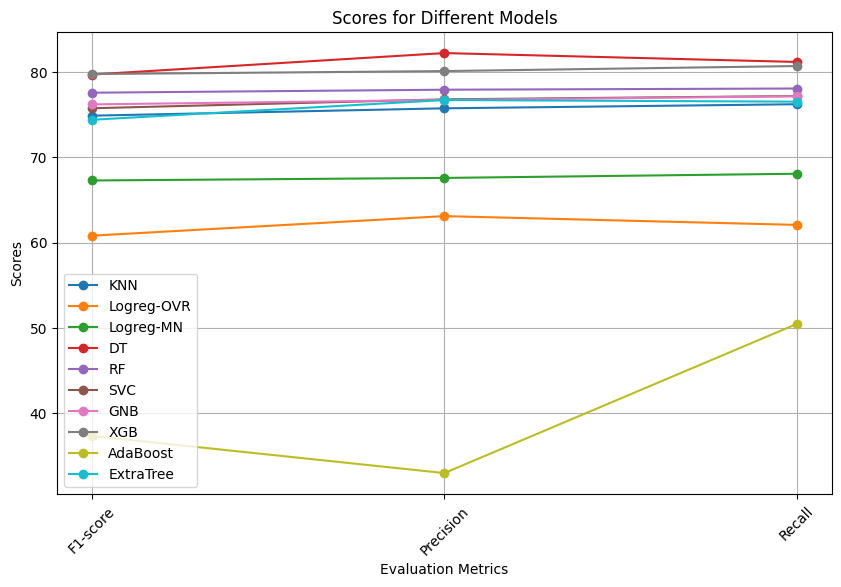

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

model_names = ['KNN', 'Logreg-OVR', 'Logreg-MN', 'DT', 'RF', 'SVC', 'GNB','XGB','AdaBoost','ExtraTree']

model_scores = [f1_scores, precision_scores, recall_scores]
score_labels = ['F1-score','Precision' ,'Recall']
plt.plot(score_labels, model_scores, marker='o', label=model_names)

plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.title('Scores for Different Models')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

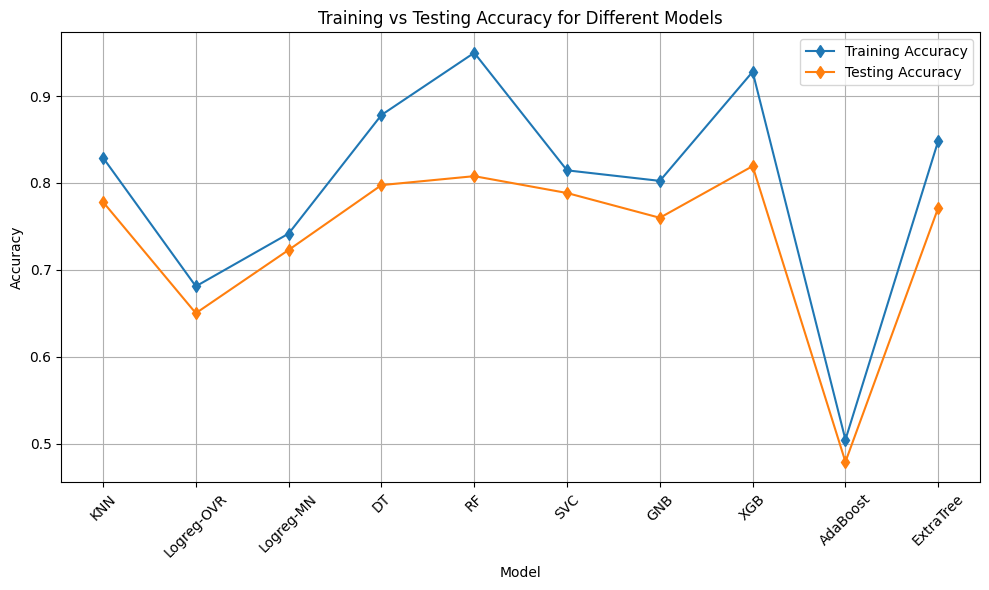

In [36]:
model_names = ['KNN', 'Logreg-OVR', 'Logreg-MN', 'DT', 'RF', 'SVC', 'GNB','XGB','AdaBoost','ExtraTree']
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_accuracies, marker='d', label='Training Accuracy')
plt.plot(model_names, test_accuracies, marker='d', label='Testing Accuracy')
plt.title('Training vs Testing Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()